In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
cons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in cons: cons[chrom] = {}
        cons[chrom][int(pos)] = float(score)

In [4]:
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms = [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms)

(37110, 70, 5) (37110, 70) 37110


In [7]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 5) (7093, 70, 5) (4306, 70, 5)
(25711, 70) (7093, 70) (4306, 70)


# Load model

In [8]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


# Baseline Model Performance

In [9]:
print y_train.shape[0], y_valid.shape[0], y_test.shape[0]

25711 7093 4306


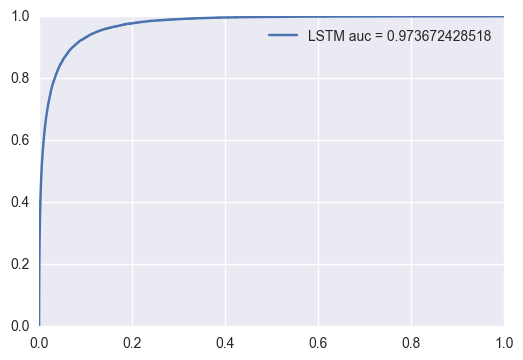

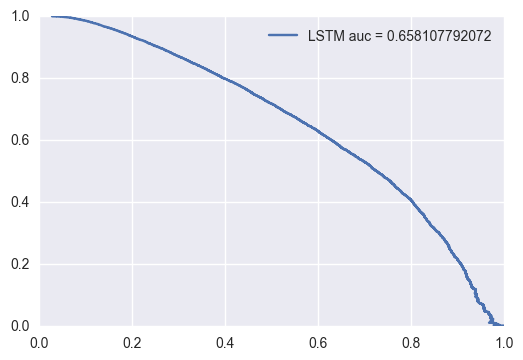

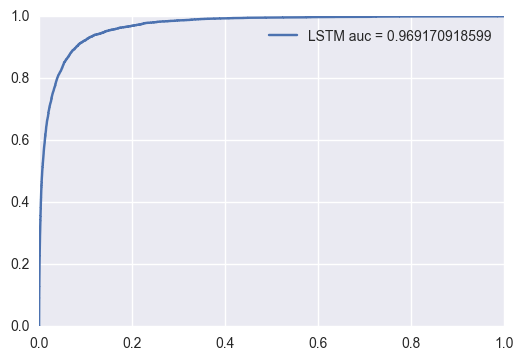

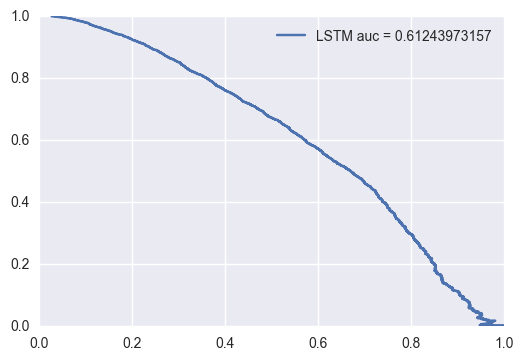

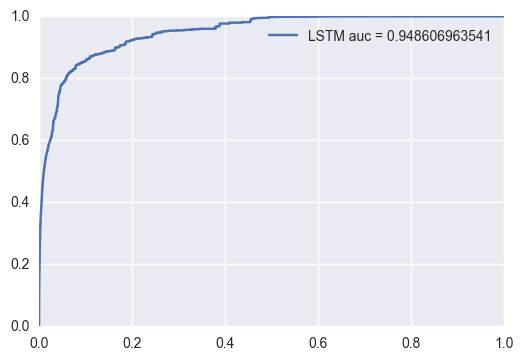

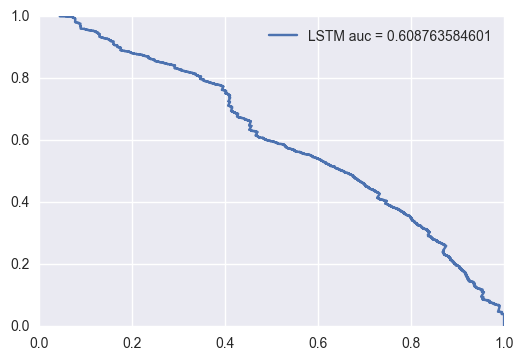

(3234, 4306)

In [10]:
def roc(preds, y, begin, end):
    truth = y[:, begin:end].flatten()
    
    scores = preds[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.show()
    
def prc(preds, y, begin, end):
    truth = y[:, begin:end].flatten()
    
    scores = preds[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth,scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))

    plt.legend(loc = 'best')
    plt.show()
    
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

def performance(X, y, model):
    preds = model.predict(X)
    roc(preds, y, 15, 45)
    prc(preds, y, 15, 45)
    return matching(preds, y)

performance(X_train[:, :, :4], y_train, model)
performance(X_valid[:, :, :4], y_valid, model)
performance(X_test[:, :, :4],  y_test, model)

3234
0 3233 4306
1 3235 4306
2 3235 4306
3 3234 4306
4 3233 4306
5 3233 4306
6 3235 4306
7 3235 4306
8 3233 4305
9 3232 4299
10 3228 4299
11 3227 4295
12 3225 4288
13 3227 4298
14 3219 4286
15 3170 4225
16 3224 4290
17 3083 4149
18 3221 4282
19 3084 4158
20 3205 4276
21 3203 4268
22 3208 4274
23 3164 4246
24 3177 4241
25 3157 4235
26 3124 4201
27 3085 4168
28 3093 4156
29 3079 4143
30 3019 4129
31 2962 4051
32 2981 4071
33 2857 3983
34 2833 3949
35 2745 3873
36 2663 3778
37 2579 3721
38 2518 3656
39 2383 3551
40 2450 3591
41 2277 3432
42 2323 3463
43 2167 3368
44 2144 3452
45 2316 3484
46 2215 3508
47 2443 3613
48 2292 3667
49 2741 3877
50 2753 3928
51 2929 4093
52 2905 4167
53 3092 4214
54 3094 4254
55 3113 4267
56 3101 4285
57 3155 4297
58 3158 4296
59 3159 4302
60 3180 4302
61 3209 4300
62 3181 4282
63 3215 4302
64 3190 4284
65 3215 4306
66 3238 4306
67 3221 4306
0 3236 4306
1 3234 4306
2 3235 4306
3 3236 4306
4 3233 4306
5 3233 4306
6 3236 4306
7 3234 4306
8 3235 4305
9 3229 4299
1

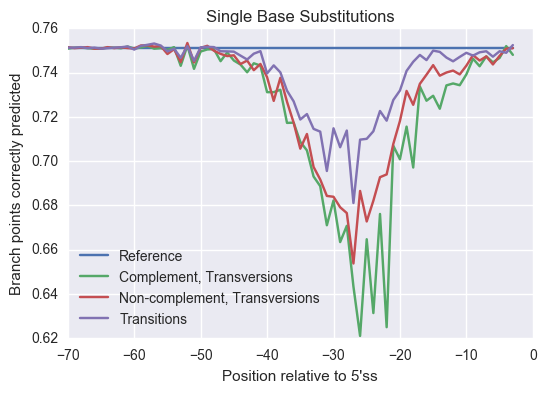

In [18]:
def _revcomp(char, MAP):
    assert char.shape == (4,)
    out = np.zeros((1, 4,))
    out[0, MAP[np.argmax(char)]] = 1
    return out

def revcomp(X, i, MAP):
    assert X.shape == (70, 4), X.shape
    return np.vstack([X[:i], _revcomp(X[i], MAP), X[i+1:]])

def ism(model, X, Y, label, MAP):
    matches, totals = [], []  
    for i in range(0, 68):
        X_mut = np.stack([revcomp(x, i, MAP)
                          for x, y in zip(X[:, :, :4], Y)
                          if 0==(y[i]+y[i+2])])
        Y_mut = np.stack([y for y in Y if 0==(y[i]+y[i+2])])
        preds = model.predict(X_mut)
        match, total = matching(preds, Y_mut)
        matches += [match]
        totals += [total]
        print i, matches[-1], totals[-1]
    plt.plot(range(-70, -2), np.array(matches) / np.array(totals).astype(float),
            label=label)

match, total = matching(model.predict(X_test[:, :, :4]), y_test)
print match
plt.plot([-70, -3], [match / float(total)]*2, label = 'Reference')
ism(model, X_test, y_test,
    'Complement, Transversions', [3, 2, 1, 0])
ism(model, X_test, y_test,
    'Non-complement, Transversions', [1, 0, 3, 2])
ism(model, X_test, y_test,
    'Transitions', [2, 3, 0, 1])
plt.legend(loc = 'best')
plt.title('Single Base Substitutions')
plt.xlabel("Position relative to 5'ss")
plt.ylabel("Branch points correctly predicted")
plt.show()

# More major changes

3234
0 3237
1 3235
2 3237
3 3237
4 3234
5 3237
6 3232
7 3226
8 3217
9 3222
10 3213
11 3221
12 3212
13 3136
14 3137
15 3064
16 3050
17 3048
18 3063
19 3039
20 3147
21 3118
22 3096
23 3062
24 3039
25 2986
26 2931
27 2890
28 2823
29 2662
30 2579
31 2512
32 2415
33 2282
34 2124
35 1990
36 1865
37 1586
38 1418
39 1324
40 1187
41 960
42 867
43 948
44 1096
45 1165
46 1219
47 1432
48 1644
49 2036
50 2201
51 2456
52 2501
53 2470
54 2449
55 2407
56 2400
57 2563
58 2587
59 2631
60 2663
61 2782
62 2929
63 3037
64 3013
0 3241
1 3237
2 3240
3 3235
4 3238
5 3235
6 3227
7 3224
8 3221
9 3229
10 3216
11 3224
12 3216
13 3147
14 3140
15 3073
16 3069
17 3068
18 3057
19 3033
20 3155
21 3132
22 3099
23 3074
24 2998
25 3003
26 2952
27 2903
28 2882
29 2713
30 2611
31 2600
32 2479
33 2339
34 2234
35 2049
36 1914
37 1699
38 1539
39 1447
40 1351
41 1225
42 1082
43 1064
44 1351
45 1303
46 1573
47 1760
48 1910
49 2085
50 2302
51 2443
52 2530
53 2601
54 2533
55 2385
56 2392
57 2561
58 2526
59 2582
60 2677
61 2751
62

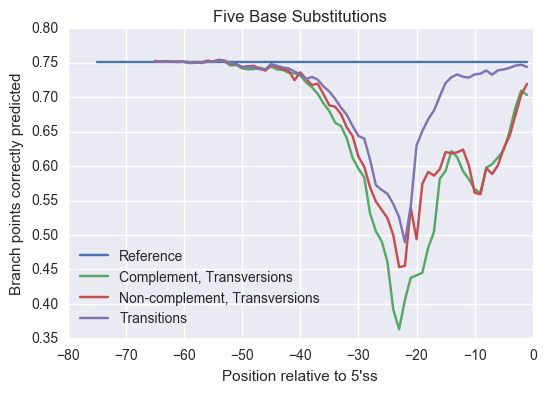

In [19]:
def _revcomp(char, MAP):
    assert char.shape == (4,)
    out = np.zeros((1, 4,))
    out[0, MAP[np.argmax(char)]] = 1
    return out

def _revcompgroup(seq, MAP):
    return np.vstack(map(lambda x: _revcomp(x, MAP), seq))

def revcomp(X, i, MAP, k):
    assert X.shape == (70, 4), X.shape
    return np.vstack([X[:i], _revcompgroup(X[i:i+k], MAP), X[i+k:]])

def region_ism(model, X, Y, label, MAP, k):
    matches, totals = [], []
    for i in range(0, 70-k):
        X_mut = np.stack([revcomp(x, i, MAP, k)
                          for x, y in zip(X[:, :, :4], Y)
                          if not sum(y[i:i+k])])
        Y_mut = np.stack([y for y in Y if not sum(y[i:i+k])])
        preds = model.predict(X_mut)
        match, total = matching(preds, Y_mut)
        matches += [match]
        totals += [total]
        print i, matches[-1]
    plt.plot(range(k-70, 0), np.array(matches) / np.array(totals).astype(float),
            label=label)

match, total = matching(model.predict(X_test[:, :, :4]), y_test)
print match
plt.plot([-75, -1], [match / float(total)]*2, label = 'Reference')
region_ism(model, X_test, y_test,
    'Complement, Transversions', [3, 2, 1, 0], 5)
region_ism(model, X_test, y_test,
    'Non-complement, Transversions', [1, 0, 3, 2], 5)
region_ism(model, X_test, y_test,
    'Transitions', [2, 3, 0, 1], 5)
plt.legend(loc='best')
plt.title('Five Base Substitutions')
plt.xlabel("Position relative to 5'ss")
plt.ylabel("Branch points correctly predicted")
plt.show()

# Relative to BP

- Look at window around predicted branchpoints that we get right

In [38]:
WINDOW = 10

def _revcomp(char, MAP):
    assert char.shape == (4,)
    out = np.zeros((1, 4,))
    out[0, MAP[np.argmax(char)]] = 1
    return out

def revcomp(X, i, MAP):
    assert X.shape == (70, 4), X.shape
    if not 0 <= i < X.shape[0]: return X
    return np.vstack([X[:i], _revcomp(X[i], MAP), X[i+1:]])

def bp_ism(model, X, bps, label, MAP):
    matches = []
    refpreds = model.predict(X)
    deltas = []
    for i in range(-WINDOW, WINDOW+1):
        X_mut = np.stack([revcomp(x, bp+i, MAP)
                          for x, bp in zip(X[:, :, :4], bps)])
        
        altpreds = model.predict(X_mut)
        
        delta = np.array([alt[bp]-ref[bp]
                          for ref, alt, bp in zip(refpreds, altpreds, bps)])
        print i, delta.mean()
        deltas += [delta]
    return np.hstack(deltas).T

# Correctly Predicted
preds = model.predict(X_test[:, :, :4])
X_test_correct, test_correct_bps = [], []
for target, truth, seq in zip(preds, y_test, X_test[:, :, :4]):
    if np.argmax(target) not in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    X_test_correct += [seq.reshape(1, 70, 4)]
    test_correct_bps += [bp]
X_test_correct = np.vstack(X_test_correct)
test_correct_bps = np.array(test_correct_bps)
print X_test_correct.shape

comp = bp_ism(model, X_test_correct, test_correct_bps,
              'Complement, Transversions', [3, 2, 1, 0])
noncomp = bp_ism(model, X_test_correct, test_correct_bps,
                 'Non-complement, Transversions', [1, 0, 3, 2])
trans = bp_ism(model, X_test_correct, test_correct_bps,
               'Transitions', [2, 3, 0, 1])

(3234, 70, 4)
-10 -0.0100126
-9 -0.0150644
-8 -0.022309
-7 -0.0266942
-6 -0.0342198
-5 -0.035883
-4 -0.0502296
-3 -0.19513
-2 -0.468277
-1 -0.0599552
0 -0.733674
1 -0.0850329
2 -0.018053
3 -0.0133234
4 -0.0426984
5 -0.0239785
6 -0.0484184
7 -0.0341328
8 -0.0663321
9 -0.0558555
10 -0.0931289
-10 -0.0154566
-9 -0.0110907
-8 -0.0218003
-7 -0.0234091
-6 -0.0264276
-5 -0.0322561
-4 -0.0429494
-3 -0.2476
-2 -0.389939
-1 -0.0813965
0 -0.612296
1 -0.0889219
2 -0.0121525
3 -0.00993733
4 -0.0204708
5 -0.017827
6 -0.0160989
7 -0.0174624
8 -0.0204701
9 -0.0295397
10 -0.0377549
-10 -0.0121282
-9 -0.0122339
-8 -0.0158616
-7 -0.0155852
-6 -0.0262912
-5 -0.0316461
-4 -0.0384018
-3 -0.0891725
-2 -0.347205
-1 -0.0332687
0 -0.70784
1 -0.0279582
2 -0.0232522
3 -0.0106832
4 -0.0200777
5 -0.0127284
6 -0.0138857
7 -0.0100897
8 -0.0115231
9 -0.0145005
10 -0.0206523


In [43]:
WINDOW = 10
X_mask = np.argmax(X_test_correct, axis = 2)
bpseqs = []
for bp, seq in zip(test_correct_bps, X_mask):
    bpseqs += [seq[bp-WINDOW:bp+WINDOW+1]]
bpseqs = np.vstack(bpseqs).T
print bpseqs.shape

(21, 3234)


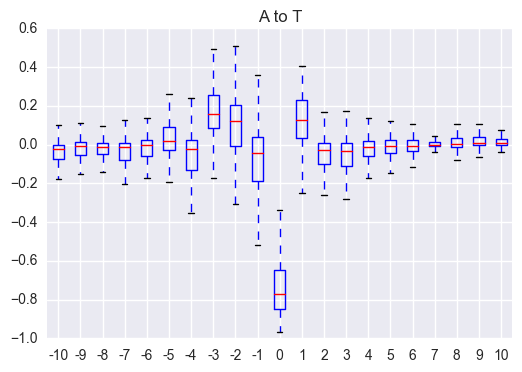

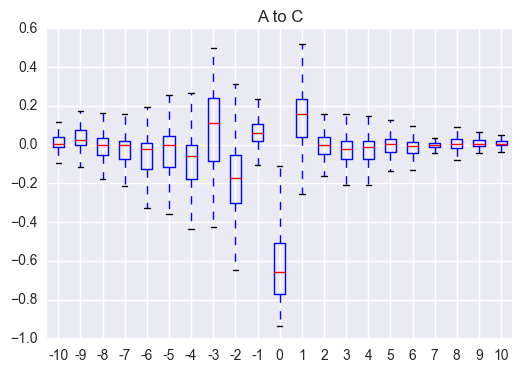

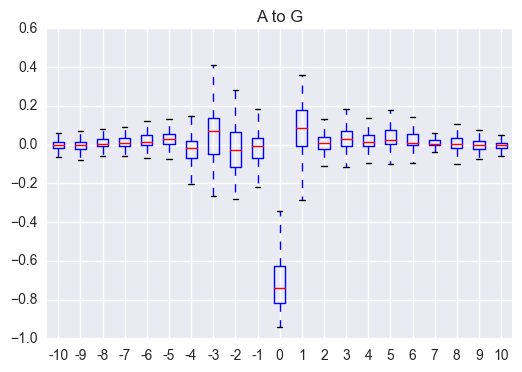

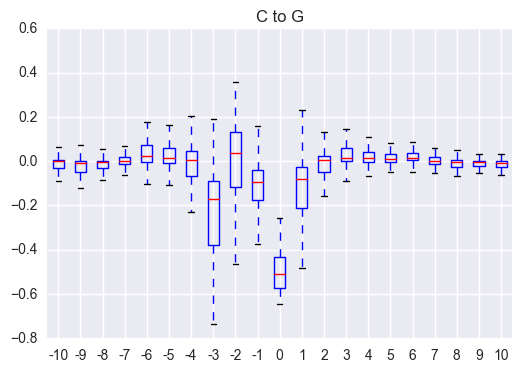

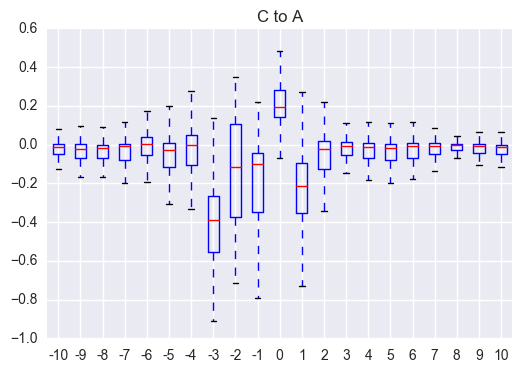

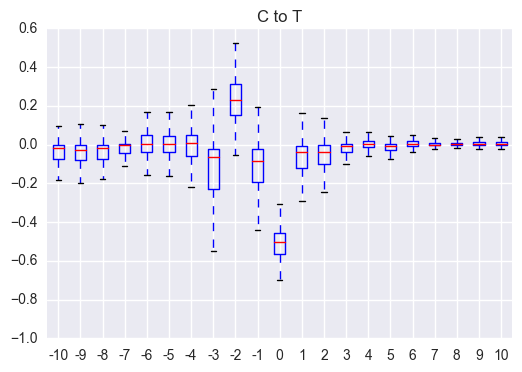

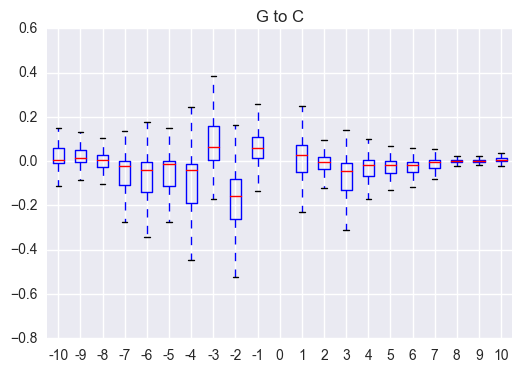

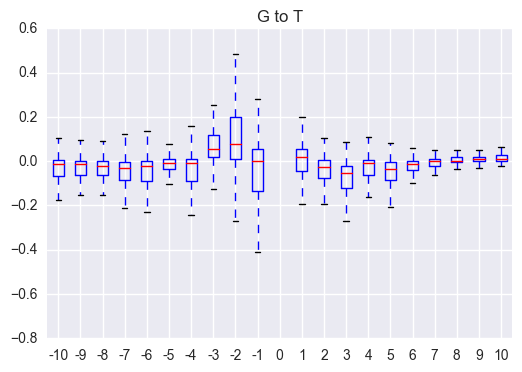

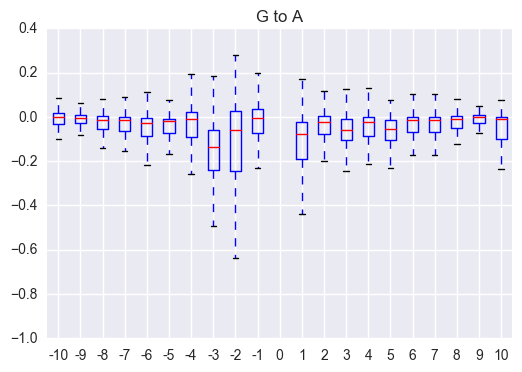

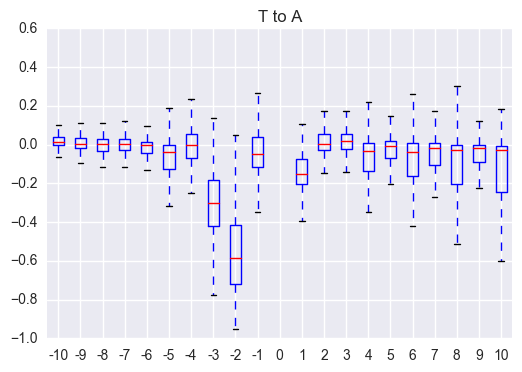

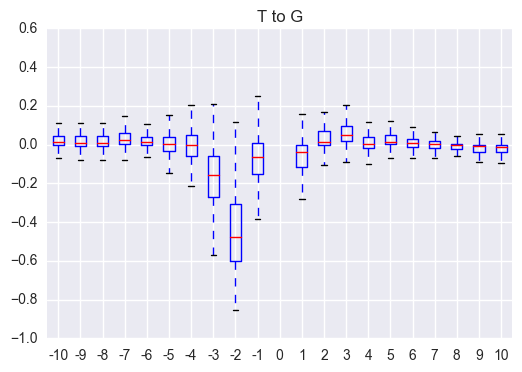

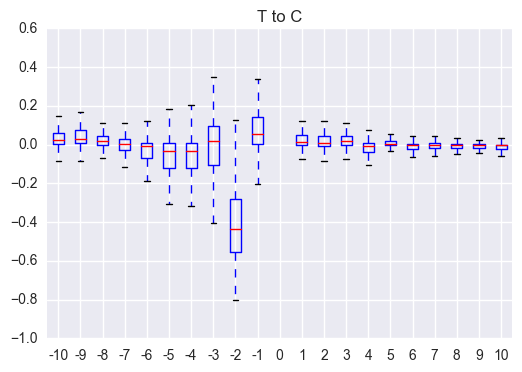

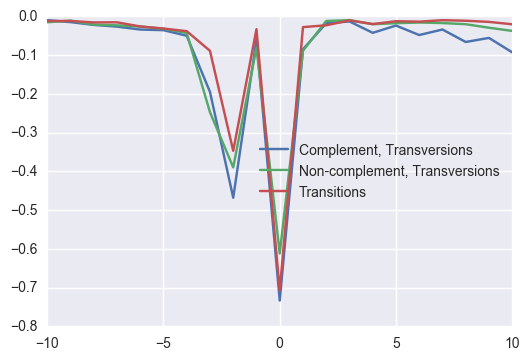

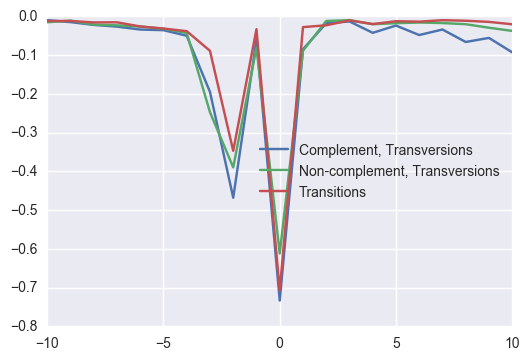

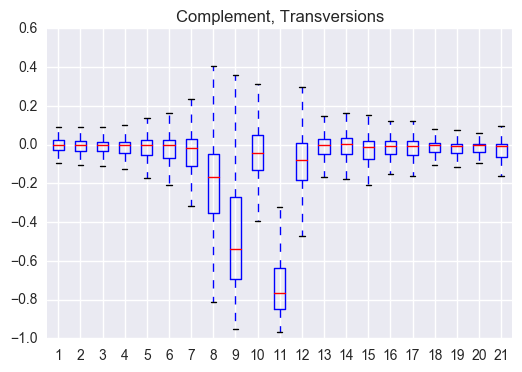

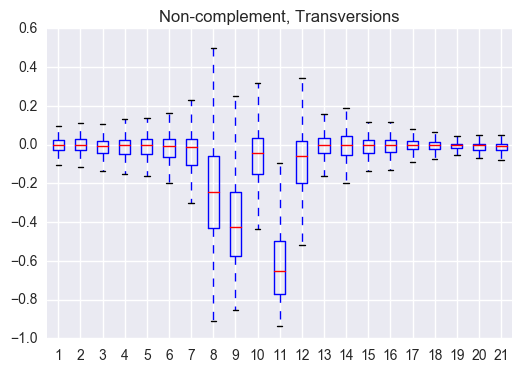

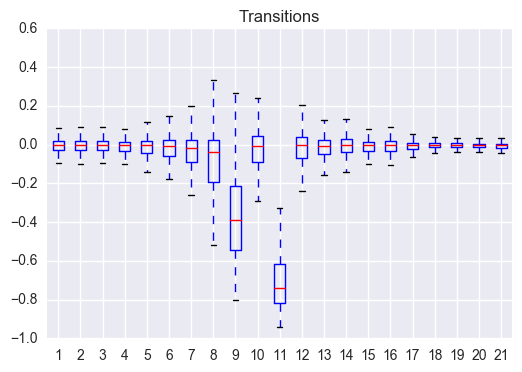

In [54]:
names = ['Complement, Transversions', 'Non-complement, Transversions', 'Transitions']
deltas = [comp, noncomp, trans]
changes = [[3, 2, 1, 0], [1, 0, 3, 2], [2, 3, 0, 1]]

for base in range(4):
    for change, delta in zip(changes, deltas):
        scores = []
        for i in range(2*WINDOW+1):
            scores += [delta[i][bpseqs[i] == base]]
        plt.boxplot(scores)
        plt.xticks(range(1, 2*WINDOW+2), range(-WINDOW, WINDOW+1))
        plt.legend(loc = 'best')
        plt.title(bases[base] + ' to '+bases[change[base]])
        plt.show()

for name, delta in zip(names, deltas):
    plt.plot(range(-WINDOW, WINDOW+1),
             delta.mean(axis = 1),
             label=name)
plt.legend(loc = 'best')
plt.show()

for name, delta in zip(names, deltas):
    plt.plot(range(-WINDOW, WINDOW+1),
             delta.mean(axis = 1),
             label=name)
plt.legend(loc = 'best')
plt.show()

names = ['Complement, Transversions', 'Non-complement, Transversions', 'Transitions']
deltas = [comp, noncomp, trans]

for name, delta in zip(names, deltas):
    plt.title(name)
    plt.boxplot(delta.T)
    plt.show()

(3234, 70, 4)
-20 3180
-19 3175
-18 3176
-17 3167
-16 3136
-15 3112
-14 3089
-13 3068
-12 3027
-11 3037
-10 2994
-9 2999
-8 2961
-7 2916
-6 2848
-5 2840
-4 2682
-3 2116
-2 854
-1 2664
0 8
1 2644
2 2896
3 2965
4 2838
5 2951
6 2800
7 2918
8 2771
9 2876
10 2683
11 2840
12 2842
13 2844
14 2785
15 2927
16 3020
17 3047
18 3017
19 3117
20 3136
-20 3185
-19 3176
-18 3170
-17 3162
-16 3144
-15 3132
-14 3096
-13 3069
-12 3062
-11 3042
-10 2943
-9 3003
-8 2978
-7 2951
-6 2898
-5 2834
-4 2770
-3 1867
-2 1253
-1 2630
0 416
1 2601
2 2925
3 2966
4 2925
5 2975
6 3005
7 2981
8 3011
9 2982
10 2973
11 2927
12 2966
13 2966
14 2983
15 3049
16 3035
17 3099
18 3105
19 3108
20 3141
-20 3190
-19 3182
-18 3189
-17 3177
-16 3162
-15 3150
-14 3124
-13 3110
-12 3118
-11 3082
-10 3019
-9 3027
-8 3003
-7 3029
-6 2935
-5 2926
-4 2867
-3 2547
-2 1401
-1 2784
0 28
1 2830
2 2853
3 3005
4 2916
5 3059
6 3019
7 3065
8 3086
9 3083
10 3057
11 3071
12 3079
13 3107
14 3098
15 3130
16 3136
17 3165
18 3156
19 3181
20 3194


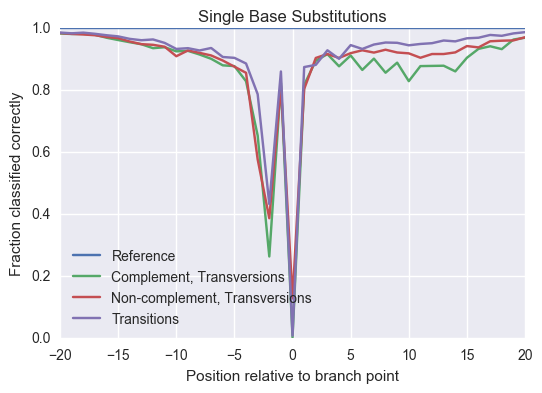

In [78]:
WINDOW = 20

def _revcomp(char, MAP):
    assert char.shape == (4,)
    out = np.zeros((1, 4,))
    out[0, MAP[np.argmax(char)]] = 1
    return out

def revcomp(X, i, MAP):
    assert X.shape == (70, 4), X.shape
    if not 0 <= i < X.shape[0]: return X
    return np.vstack([X[:i], _revcomp(X[i], MAP), X[i+1:]])

def bp_ism(model, X, bps, label, MAP):
    matches = []  
    for i in range(-WINDOW, WINDOW+1):
        X_mut = np.stack([revcomp(x, bp+i, MAP)
                          for x, bp in zip(X[:, :, :4], bps)])
        preds = model.predict(X_mut)
        
        Y = np.zeros((preds.shape[0], L))
        for j, bp in enumerate(bps):
            Y[j, bp] = 1
        
        match, total = matching(preds, Y)
        matches += [match]
        print i, matches[-1]
    plt.plot(range(-WINDOW, WINDOW+1),
             np.array(matches) / float(X.shape[0]),
             label=label)

# Correctly Predicted
preds = model.predict(X_test[:, :, :4])
X_test_correct, test_correct_bps = [], []
for target, truth, seq in zip(preds, y_test, X_test[:, :, :4]):
    if np.argmax(target) not in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    X_test_correct += [seq.reshape(1, 70, 4)]
    test_correct_bps += [bp]
X_test_correct = np.vstack(X_test_correct)
test_correct_bps = np.array(test_correct_bps)
print X_test_correct.shape

plt.plot([-WINDOW, WINDOW], [1, 1], label = 'Reference')
bp_ism(model, X_test_correct, test_correct_bps,
    'Complement, Transversions', [3, 2, 1, 0])
bp_ism(model, X_test_correct, test_correct_bps,
    'Non-complement, Transversions', [1, 0, 3, 2])
bp_ism(model, X_test_correct, test_correct_bps,
    'Transitions', [2, 3, 0, 1])
plt.legend(loc = 'best')
plt.ylabel('Fraction classified correctly')
plt.xlabel('Position relative to branch point')
plt.title('Single Base Substitutions')
plt.show()

# Mix and Match

In [44]:
# Correctly Predicted
preds = model.predict(X_test[:, :, :4])
X_test_correct, test_correct_bps = [], []

for p, t, seq in zip(preds, y_test, X_test[:, :, :4]):
    if np.argmax(p) not in np.nonzero(t)[0]: continue
    bp = np.argmax(p)
    X_test_correct += [seq.reshape(1, 70, 4)]
    test_correct_bps += [bp]

X_test_correct = np.vstack(X_test_correct)
test_correct_bps = np.array(test_correct_bps)
print X_test_correct.shape, test_correct_bps.shape

(3234, 70, 4) (3234,)


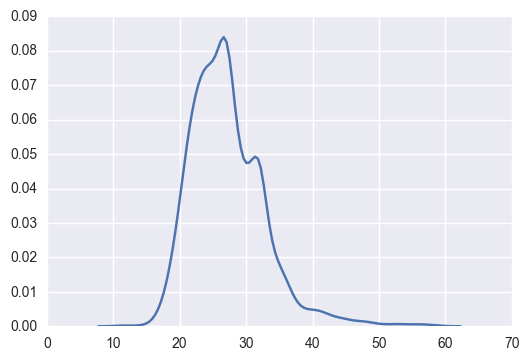

In [45]:
sns.kdeplot(70 - test_correct_bps)
plt.show()

In [46]:
X_dist = X_test_correct[(30 < 70 - test_correct_bps)
                        & (70 - test_correct_bps < 50)][:550]

b_dist = test_correct_bps[(30 < 70 - test_correct_bps)
                          & (70 - test_correct_bps < 50)][:550]

X_prox = X_test_correct[(15 < 70 - test_correct_bps)
                          & (70 - test_correct_bps < 23)][:550]

b_prox = test_correct_bps[(15 < 70 - test_correct_bps)
                          & (70 - test_correct_bps < 23)][:550]

print X_prox.shape, X_dist.shape, b_prox.shape, b_dist.shape

(550, 70, 4) (550, 70, 4) (550,) (550,)


In [66]:
def change(preds, truth, title, label, shift):
    closer, same, farther = 0, 0, 0
    for p, t in zip(preds, truth):
        bp = np.argmax(p)
        if bp > t:
            closer += 1
        elif bp == t:
            same += 1
        else:
            farther += 1

    barwidth = 0.35
    index = np.array(range(3))
    print closer, same, farther
    
    plt.bar(index + shift*barwidth, [closer, same, farther], barwidth,
            alpha=0.5, color = 'g' if shift else 'b', label = label)
    if shift:
        plt.xticks(index+barwidth, ['closer', 'same', 'farther'])
        plt.ylabel('Counts')
        plt.title(title)
        plt.legend(loc = 'best')
        plt.show()

# Exchange core splice

1 516 33
24 524 2


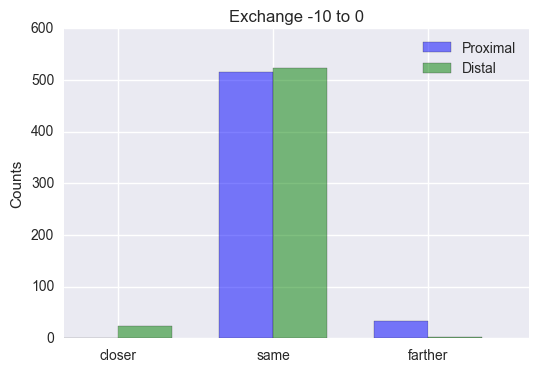

In [67]:
X_prox_dist = np.hstack([X_prox[:, :60], X_dist[:, 60:]])
X_dist_prox = np.hstack([X_dist[:, :60], X_prox[:, 60:]])

preds_prox = model.predict(X_prox_dist)
preds_dist = model.predict(X_dist_prox)

change(preds_prox, b_prox, 'Exchange -10 to 0', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange -10 to 0', 'Distal', True)

3 524 23
24 525 1


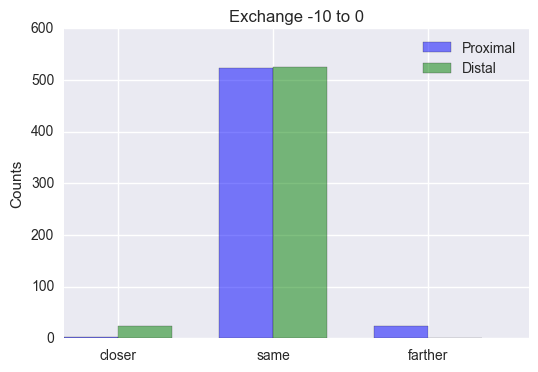

In [68]:
from sklearn.utils import shuffle

X_prox_shuffle = np.hstack([X_prox[:, :60], shuffle(X_prox[:, 60:])])
X_dist_shuffle = np.hstack([X_dist[:, :60], shuffle(X_dist[:, 60:])])

preds_prox = model.predict(X_prox_shuffle)
preds_dist = model.predict(X_dist_shuffle)

change(preds_prox, b_prox, 'Exchange -10 to 0', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange -10 to 0', 'Distal', True)

# Exchange Intronic

1 543 6
1 538 11


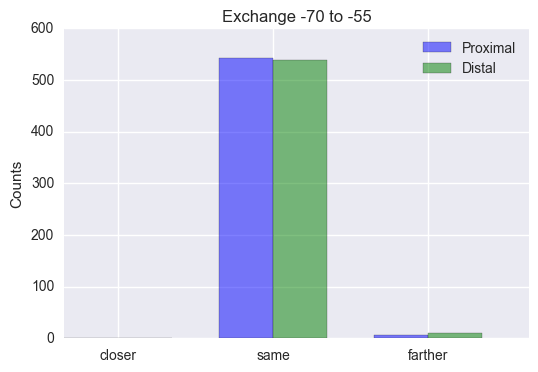

In [69]:
X_prox_dist = np.hstack([X_prox[:, :15], X_dist[:, 15:]])
X_dist_prox = np.hstack([X_dist[:, :15], X_prox[:, 15:]])

preds_dist = model.predict(X_prox_dist)
preds_prox = model.predict(X_dist_prox)

change(preds_prox, b_prox, 'Exchange -70 to -55', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange -70 to -55', 'Distal', True)

0 546 4
5 537 8


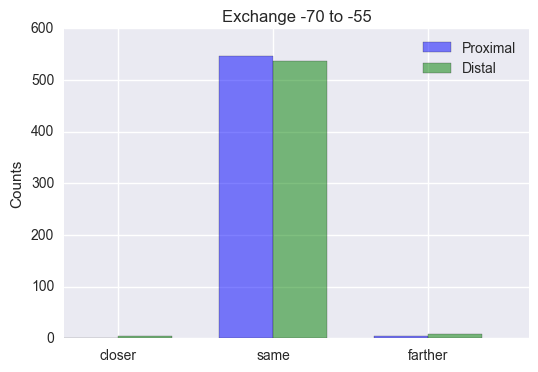

In [70]:
X_prox_dist = np.hstack([shuffle(X_dist[:, :15]), X_dist[:, 15:]])
X_dist_prox = np.hstack([shuffle(X_prox[:, :15]), X_prox[:, 15:]])

preds_dist = model.predict(X_prox_dist)
preds_prox = model.predict(X_dist_prox)

change(preds_prox, b_prox, 'Exchange -70 to -55', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange -70 to -55', 'Distal', True)

# Exchange both sides of the context

1 517 32
25 520 5


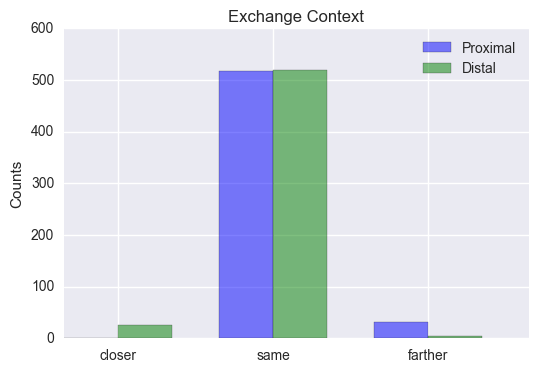

In [71]:
X_prox_dist = np.hstack([X_dist[:, :15], X_prox[:, 15:60], X_dist[:, 60:]])
X_dist_prox = np.hstack([X_prox[:, :15], X_dist[:, 15:60], X_prox[:, 60:]])

preds_prox = model.predict(X_prox_dist)
preds_dist = model.predict(X_dist_prox)

change(preds_prox, b_prox, 'Exchange Context', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange Context', 'Distal', True)

3 521 26
22 519 9


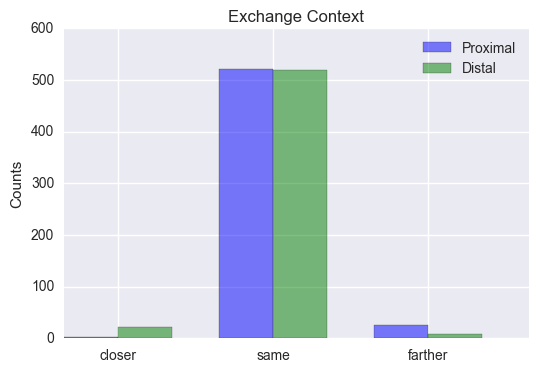

In [72]:
X_prox_dist = np.hstack([shuffle(X_dist[:, :15]), X_dist[:, 15:60], shuffle(X_dist[:, 60:])])
X_dist_prox = np.hstack([shuffle(X_prox[:, :15]), X_prox[:, 15:60], shuffle(X_prox[:, 60:])])

preds_dist = model.predict(X_prox_dist)
preds_prox = model.predict(X_dist_prox)

change(preds_prox, b_prox, 'Exchange Context', 'Proximal', False)
change(preds_dist, b_dist, 'Exchange Context', 'Distal', True)

# Competition

6 346 198
428 110 12


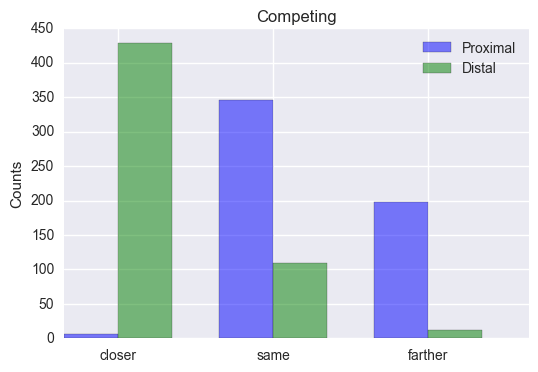

27 10 513
400 30 120


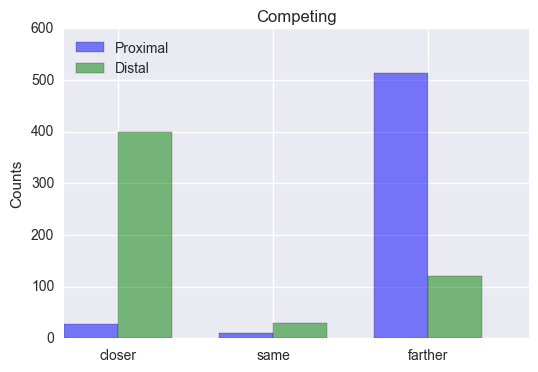

In [80]:
X_no_bp = np.hstack([X_prox[:, :43], X_dist[:, 43:]])

X_bp    = np.hstack([X_dist[:, :43], X_prox[:, 43:]])

preds_bp = model.predict(X_bp)
preds_no_bp = model.predict(X_no_bp)

change(preds_bp, b_prox, 'Competing', 'Proximal', False)
change(preds_bp, b_dist, 'Competing', 'Distal', True)

change(preds_no_bp, b_prox, 'Competing', 'Proximal', False)
change(preds_no_bp, b_dist, 'Competing', 'Distal', True)

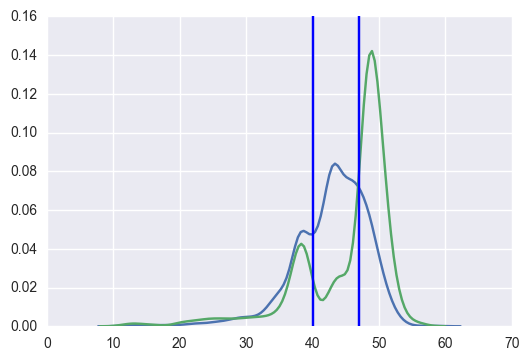

In [79]:
sns.kdeplot(test_correct_bps)
#sns.kdeplot(np.argmax(preds_no_bp, axis = 1).flatten())
sns.kdeplot(np.argmax(preds_bp, axis = 1).flatten())
plt.axvline(40)
plt.axvline(47)